# Modelo de analise das metricas RFV

## Imports

In [188]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from pydantic_settings import BaseSettings

import sidetable
import missingno as msno
from ipywidgets import interact, widgets

from sklearn import datasets
from sklearn.preprocessing import scale, minmax_scale, power_transform

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Base de Dados

### Importando o dataset

In [189]:
dadosBase = pd.read_csv("data.csv", sep=',', encoding='latin1')
dadosBase

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


# Analise Exploratória + Pré Processamento dos dados

In [190]:
dadosBase.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [191]:
dadosBase.drop(columns=['CustomerID']).describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


## Tratamento da Base de Dados

### Valores faltante na identificação do cliente

In [192]:
# Identificar e mostrar valores nulos
df_missing = (
  dadosBase.isna().sum()
  .to_frame('qtd_dadosfaltantes')
  .join((dadosBase.isna().sum() / dadosBase.shape[0]).to_frame('percentagem_dadosfaltantes'))
  .sort_values('qtd_dadosfaltantes', ascending=False)
)

df_missing.style.format('{:.2%}', subset=['percentagem_dadosfaltantes'])

,qtd_dadosfaltantes,percentagem_dadosfaltantes
CustomerID,135080,24.93%
Description,1454,0.27%
InvoiceNo,0,0.00%
StockCode,0,0.00%
Quantity,0,0.00%
InvoiceDate,0,0.00%
UnitPrice,0,0.00%
Country,0,0.00%


In [193]:
dadosBase.stb.missing()

,missing,total,percent
CustomerID,135080,541909,24.926694
Description,1454,541909,0.268311
InvoiceNo,0,541909,0.000000
StockCode,0,541909,0.000000
Quantity,0,541909,0.000000
InvoiceDate,0,541909,0.000000
UnitPrice,0,541909,0.000000
Country,0,541909,0.000000


<Axes: >

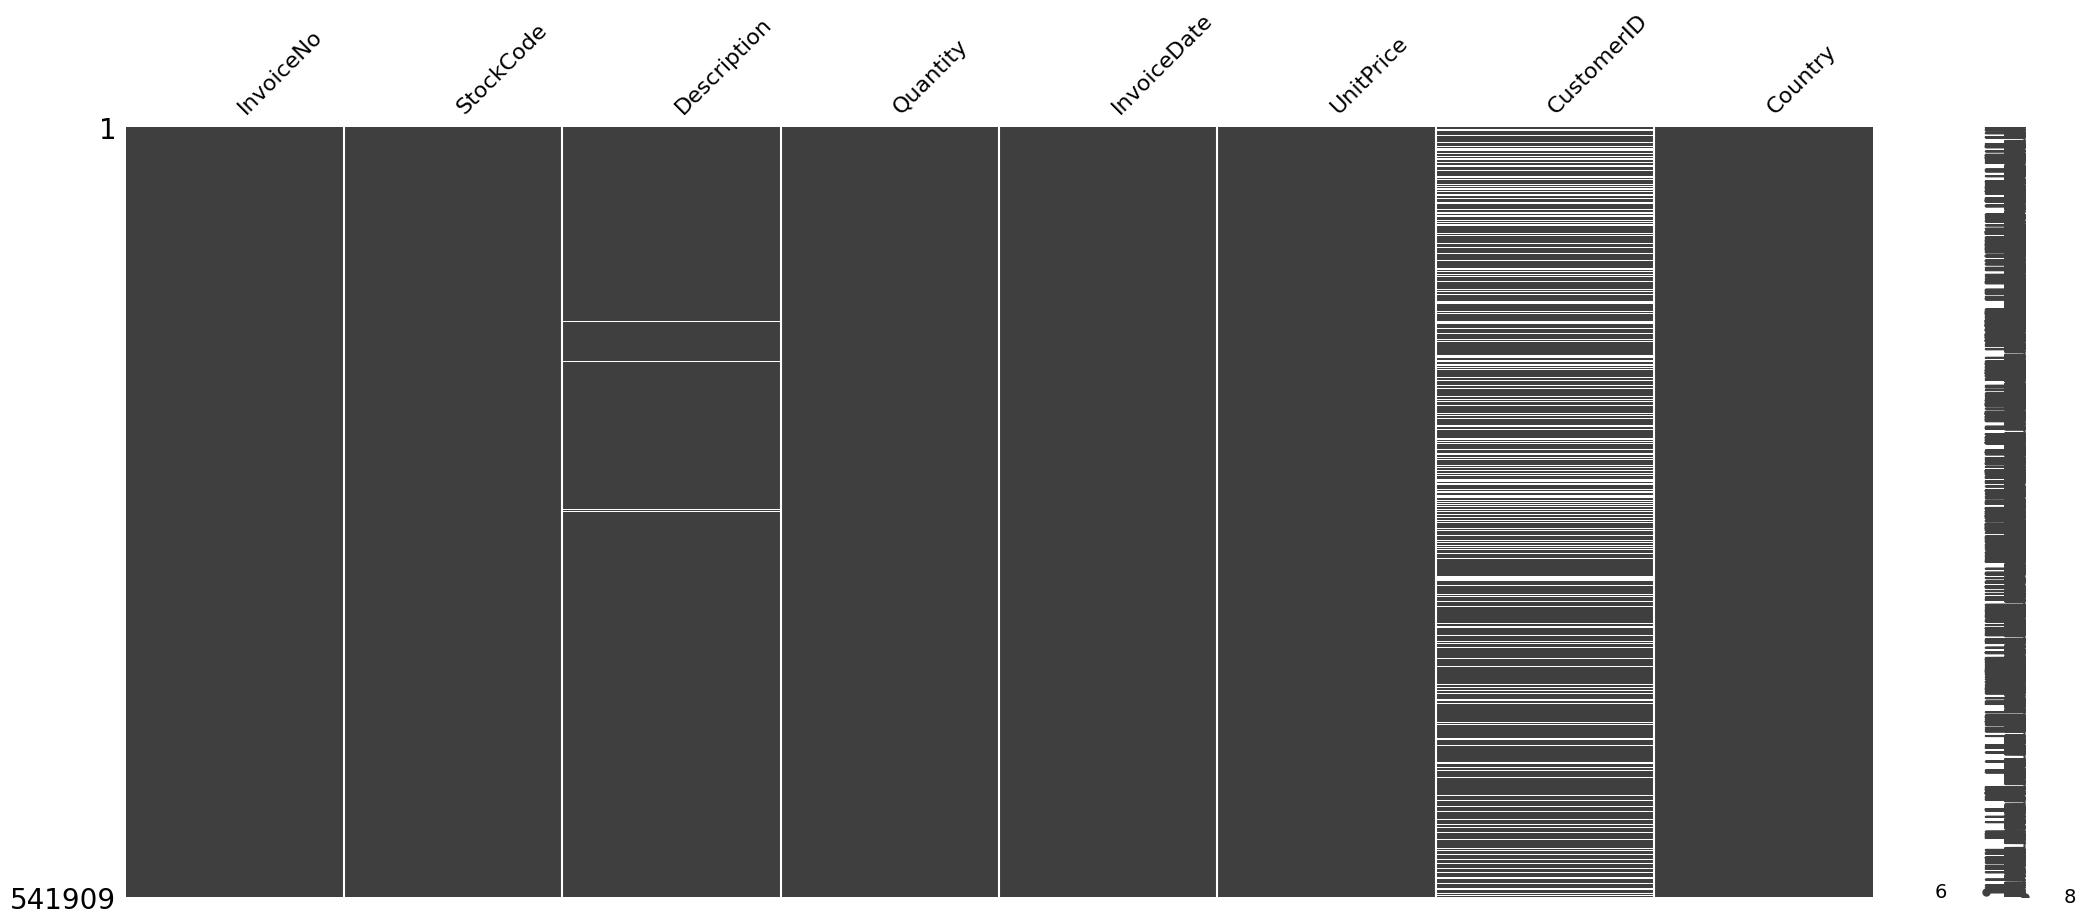

In [194]:
msno.matrix(dadosBase)

In [195]:
dB_withoutNulls_CustomerID = dadosBase.dropna(subset=['CustomerID']).copy()

In [196]:
dB_withoutNulls_CustomerID.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


In [197]:
dB_withoutNulls_CustomerID.stb.missing()

,missing,total,percent
InvoiceNo,0,406829,0.0
StockCode,0,406829,0.0
Description,0,406829,0.0
Quantity,0,406829,0.0
InvoiceDate,0,406829,0.0
UnitPrice,0,406829,0.0
CustomerID,0,406829,0.0
Country,0,406829,0.0


### Preços unitários e quantidade de produtos iguais ou inferior a 0

In [198]:
dB_withoutNulls = dB_withoutNulls_CustomerID.copy()

In [199]:
# Função para limpar valores nulos e menores que zero
def clean_dataframe(df, column):
    null_values = df[column].isnull().any()
    zero_values = (df[column] <= 0).any()

    if null_values:
        print(f"A coluna {column} possui valores nulos.")
        df = df.dropna(subset=[column])
    else:
        print(f"A coluna {column} não possui valores nulos.")

    if zero_values:
        print(f"A coluna {column} possui valores menores ou iguais a zero.")
        df = df[df[column] > 0]

    return df

# Supondo que você tenha o DataFrame dB_withougNulls já carregado

# Limpar coluna 'UnitPrice'
dB_cleaned_UnitPrice = clean_dataframe(dB_withoutNulls, 'UnitPrice')

# Limpar coluna 'Quantity'
dB_cleaned_Quantity = clean_dataframe(dB_cleaned_UnitPrice, 'Quantity')


A coluna UnitPrice não possui valores nulos.
A coluna UnitPrice possui valores menores ou iguais a zero.
A coluna Quantity não possui valores nulos.
A coluna Quantity possui valores menores ou iguais a zero.


In [200]:
dB_cleaned_Quantity.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397884 non-null  object 
 1   StockCode    397884 non-null  object 
 2   Description  397884 non-null  object 
 3   Quantity     397884 non-null  int64  
 4   InvoiceDate  397884 non-null  object 
 5   UnitPrice    397884 non-null  float64
 6   CustomerID   397884 non-null  float64
 7   Country      397884 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.3+ MB


### Verifique se existem linhas duplicadas


In [201]:
dB_viewDuplicate = dB_cleaned_Quantity.copy()
dB_withoutDuplicate = dB_viewDuplicate.drop_duplicates().copy()
dB_withoutDuplicate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392692 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    392692 non-null  object 
 1   StockCode    392692 non-null  object 
 2   Description  392692 non-null  object 
 3   Quantity     392692 non-null  int64  
 4   InvoiceDate  392692 non-null  object 
 5   UnitPrice    392692 non-null  float64
 6   CustomerID   392692 non-null  float64
 7   Country      392692 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.0+ MB


### Tipo de dados da coluna

In [202]:
dB_typeData = dB_withoutDuplicate.copy()

In [203]:
dB_typeData['InvoiceDate'] = pd.to_datetime(dB_typeData['InvoiceDate'], format='%m/%d/%Y %H:%M')
dB_typeData['CustomerID'] = dB_typeData['CustomerID'].astype('string')

In [204]:
dB_typeData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392692 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  string        
 7   Country      392692 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4), string(1)
memory usage: 27.0+ MB


### Tratando os outliers

In [205]:
dB_TreatingOutliers = dB_typeData.copy()

In [206]:
print(dB_TreatingOutliers.shape)
dB_TreatingOutliers.head(3)

(392692, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [207]:
dB_TreatingOutliers['CustomerID'] = dB_TreatingOutliers['CustomerID'].astype('str')


def get_numeric_columns(df):
    numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
    return numeric_columns

# Uso:
numeric_columns = get_numeric_columns(dB_TreatingOutliers)
print(numeric_columns)

['Quantity', 'UnitPrice']


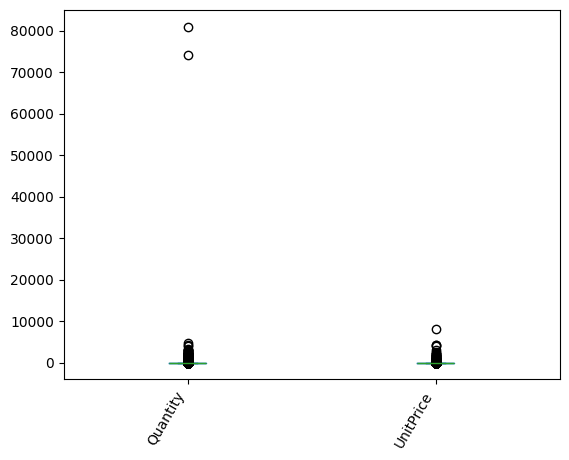

In [208]:
# Identificando outlier
# Box plot com dados "as is"
dB_TreatingOutliers[numeric_columns].plot.box()
plt.xticks(rotation=60, ha='right');

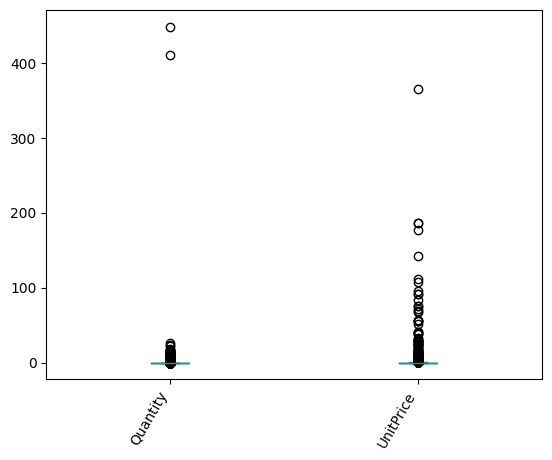

In [209]:
# Box plot com dados padronizados
dB_TreatingOutliers[numeric_columns].apply(scale).plot.box()
plt.xticks(rotation=60, ha='right');

In [210]:
dB_TreatingOutliers.tail(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [211]:
def is_outlier(array, extreme=False):
  """Custom function to identify outliers in an array"""
  q1,q3 = np.quantile(array, [.25,.75])
  iqr = q3-q1

  factor = 3. if extreme else 1.5
  upper_outlier = q3 + factor*iqr
  lower_outlier = q1 - factor*iqr

  return (array < lower_outlier) | (array > upper_outlier)

In [212]:
# Mostrando aplicação da função para todas colunas numéricas contínuas
dB_TreatingOutliers[numeric_columns].apply(lambda col: is_outlier(col) if np.issubdtype(col.dtype, np.number) else False)


,Quantity,UnitPrice
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
541904,False,False
541905,False,False
541906,False,False
541907,False,False


In [213]:
# Calculando quantidade de outliers
dB_TreatingOutliers[numeric_columns].apply(lambda col: is_outlier(col) if np.issubdtype(col.dtype, np.number) else False).sum()

Quantity     25616
UnitPrice    34112
dtype: int64

In [214]:
# Removendo outliers
dB_withoutOutliers = dB_TreatingOutliers[~dB_TreatingOutliers[numeric_columns].apply(is_outlier).any(axis=1)]

In [215]:
dB_withoutOutliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 333234 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    333234 non-null  object        
 1   StockCode    333234 non-null  object        
 2   Description  333234 non-null  object        
 3   Quantity     333234 non-null  int64         
 4   InvoiceDate  333234 non-null  datetime64[ns]
 5   UnitPrice    333234 non-null  float64       
 6   CustomerID   333234 non-null  object        
 7   Country      333234 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 22.9+ MB


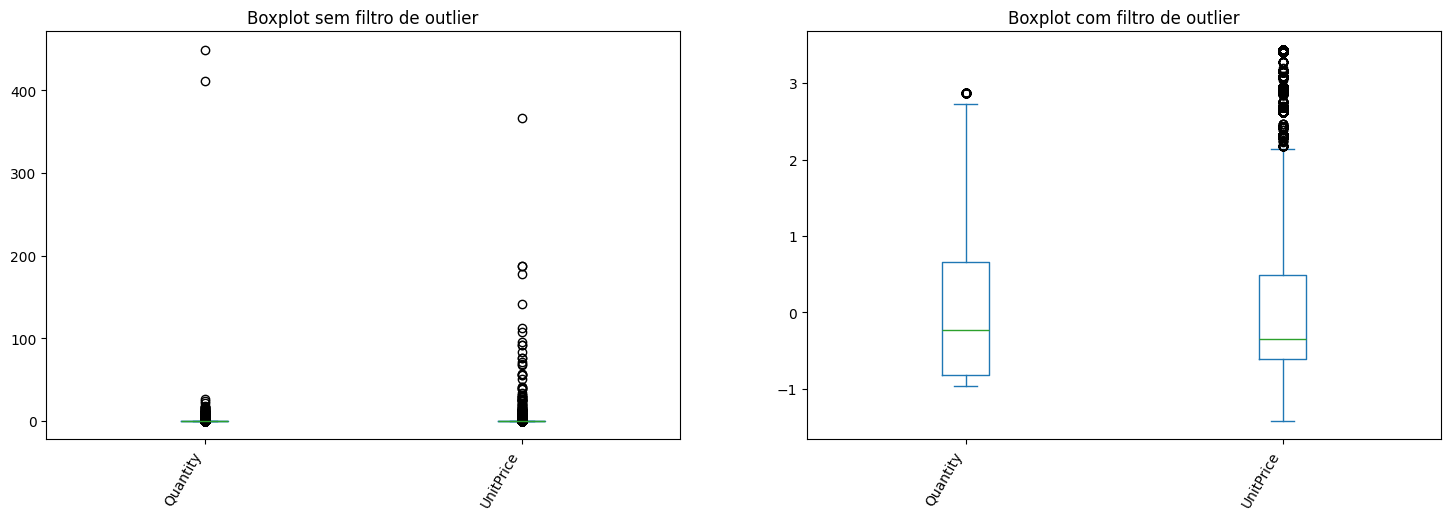

In [216]:
# Figura lado a lado dos dados originais e padronizados
fig,axes = plt.subplots(ncols=2, figsize=(18,6))

dB_TreatingOutliers[numeric_columns].apply(scale).plot.box(ax=axes[0], title='Boxplot sem filtro de outlier')
dB_withoutOutliers[numeric_columns].apply(scale).plot.box(ax=axes[1], title='Boxplot com filtro de outlier')

fig.autofmt_xdate(rotation=60, ha='right')
plt.show()

In [217]:
register_outlier = len(dB_withoutOutliers.query('Quantity >= 10000 or UnitPrice >= 5000'))
if register_outlier > 0:
   dB_withoutOutliers = dB_withoutOutliers.query('Quantity <= 10000 or UnitPrice <= 5000').copy()
   print(f"Há {register_outlier} de registros com outliers.")
else:
   dB_withoutOutliers
   print("Sem registros com outliers.")


Sem registros com outliers.


In [218]:
df = dB_withoutOutliers.copy()

### Normalizando os dados

In [219]:
# Normaliza as features
df_normalized = dB_withoutOutliers.copy()
scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(df[['Quantity', 'UnitPrice']])
# Colunas do DataFrame
columns = ['Quantity', 'UnitPrice']
# Criar o DataFrame
df_normalized = pd.DataFrame(df_normalized, columns=columns)

#  Algoritmo de clusterização

[21215.805789543287, 11578.287216180692, 6474.485571936426, 4726.078019503781, 4245.058112522585, 3670.1580626253294, 3448.454024956898, 3002.6593921880535, 2604.818563845396]


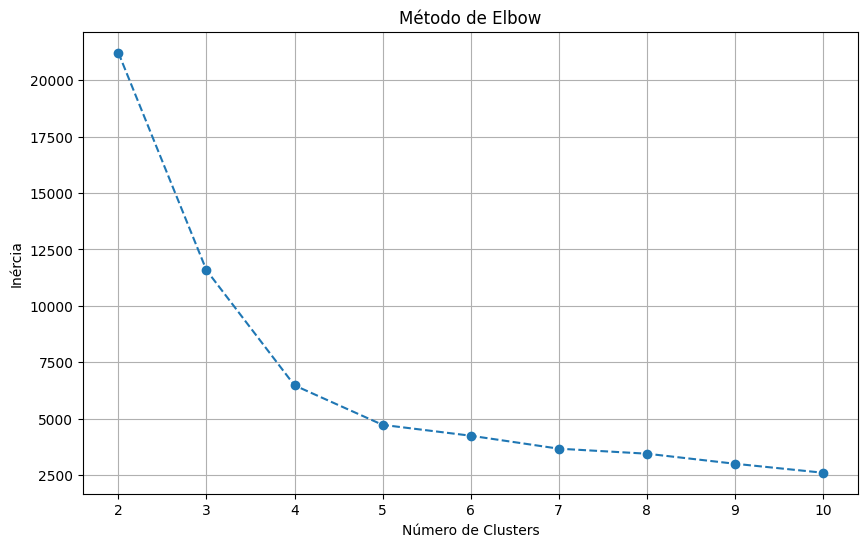

In [220]:
# Encontra o número ideal de clusters usando o Método de Elbow
inertia = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(df_normalized)
    inertia.append(kmeans.inertia_)
print(inertia)
# Plotagem do Método de Elbow
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), inertia, marker='o', linestyle='--')
plt.title('Método de Elbow')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()



O 4 é o numero ideial de clusters, uma vez que é o ponto onde a diminuição na inércia começa a diminuir significativamente, este ponto é frequentemente chamado de "cotovelo" do gráfico, e também é o ponto no gráfico onde a diminuição na inércia começa a se nivelar, o que indica que adicionar mais clusters não está fornecendo uma melhoria significativa na compactação dos dados.

In [221]:
# Implementa o KMeans com o número de clusters escolhido (4)
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_normalized)

# Analisa os clusters
cluster_analysis = df.groupby('Cluster').agg({
    'Quantity': 'mean',
    'UnitPrice': 'mean',
    'CustomerID': 'count',
    'Country': lambda x: x.value_counts().index[0],
    'Description': lambda x: x.value_counts().index[0]
}).rename(columns={'Quantity': 'Média_Quantidade', 'UnitPrice': 'Média_PreçoUnitário', 'CustomerID': 'Total_Clientes'})

print(cluster_analysis)

         Média_Quantidade  Média_PreçoUnitário  Total_Clientes  \
Cluster                                                          
0                2.881151             1.471259          116038   
1               23.384902             1.092020           34640   
2                3.713770             4.262141           92181   
3               11.390639             1.435687           90375   

                Country                         Description  
Cluster                                                      
0        United Kingdom        REX CASH+CARRY JUMBO SHOPPER  
1        United Kingdom     PACK OF 72 RETROSPOT CAKE CASES  
2        United Kingdom  WHITE HANGING HEART T-LIGHT HOLDER  
3        United Kingdom       ASSORTED COLOUR BIRD ORNAMENT  


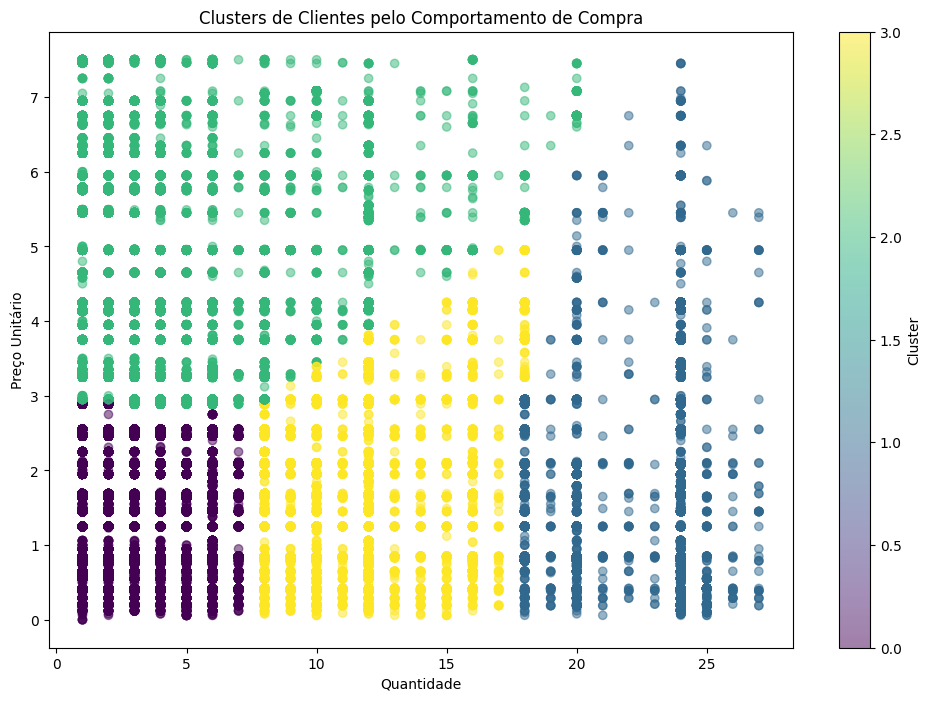

In [222]:
# Plotagem dos clusters
plt.figure(figsize=(12, 8))
plt.scatter(df['Quantity'], df['UnitPrice'], c=df['Cluster'], cmap='viridis', alpha=0.5)
plt.title('Clusters de Clientes pelo Comportamento de Compra')
plt.xlabel('Quantidade')
plt.ylabel('Preço Unitário')
plt.colorbar(label='Cluster')
plt.show()

In [223]:
# Interpretação dos resultados
# Descreve o perfil de compra dos clientes em cada cluster
# Cluster 0
print("Cluster 0:")
print(df[df['Cluster'] == 0].describe())
# Cluster 1
print("\nCluster 1:")
print(df[df['Cluster'] == 1].describe())
# Cluster 2
print("\nCluster 2:")
print(df[df['Cluster'] == 2].describe())
# Cluster 3
print("\nCluster 3:")
print(df[df['Cluster'] == 3].describe())

Cluster 0:
            Quantity                    InvoiceDate      UnitPrice   Cluster
count  116038.000000                         116038  116038.000000  116038.0
mean        2.881151  2011-07-18 20:55:51.430565888       1.471259       0.0
min         1.000000            2010-12-01 08:26:00       0.001000       0.0
25%         1.000000            2011-04-11 13:41:00       0.850000       0.0
50%         2.000000            2011-08-16 13:50:00       1.450000       0.0
75%         4.000000            2011-11-01 10:16:00       2.080000       0.0
max         7.000000            2011-12-09 12:50:00       2.900000       0.0
std         1.848861                            NaN       0.640582       0.0

Cluster 1:
           Quantity                    InvoiceDate     UnitPrice  Cluster
count  34640.000000                          34640  34640.000000  34640.0
mean      23.384902  2011-07-11 05:04:46.700923648      1.092020      1.0
min       18.000000            2010-12-01 08:45:00      0.0600

Justificativa da utilidade da análise para segmentação de clientes e personalização de campanhas de marketing
* Ao segmentar clientes em clusters com base em seu comportamento de compra, a empresa pode entender e direcionar segmentos específicos de clientes. 
    
    Por exemplo, o atual cenário: 
     * O Cluster 0 representa compradores ocasionais com menor gasto.
     * O Cluster 1 representa clientes de alta frequencia de compram e gastam uma quantia média/baixa por transação.
     * O Cluster 2 representa cliente de médio gasto e frequencia de compra.
     * O Clauster 3 representa clientes de alto valor, com baixa/média de frequencia de compra. 

Esses insights podem ajudar a adaptar campanhas de marketing às preferências e comportamentos de cada segmento, levando a estratégias de marketing mais eficazes e personalizadas.


* Cluster 0: “Exploradores Esporádicos” - Este nome reflete a natureza ocasional das compras e o menor gasto desses clientes.
* Cluster 1: “Habituais Econômicos” - Indica que esses clientes compram frequentemente, mas mantêm um nível de gasto médio a baixo por transação.
* Cluster 2: “Moderados Constantes” - Sugere um equilíbrio entre a frequência de compra e o montante gasto.
* Cluster 3: “Elite Seletiva” - Transmite a ideia de que esses clientes são de alto valor, mas fazem compras com uma frequência baixa a média.

Ações possíveis com base na análise realizada
* Desenvolver campanhas de marketing direcionadas às preferências e comportamentos de cada cluster
* Oferecer promoções e descontos personalizados para incentivar compras repetidas
* Introduzir programas de fidelidade para clusters de alto valor para retê-los
* Analisar as preferências de produto de cada cluster e otimizar o estoque e as ofertas de produtos de acordo.

In [224]:
# Definindo o mapeamento de valores
mapeamento = {0: "Exploradores Esporádicos", 
              1: "Habituais Econômicos", 
              2: "Moderados Constantes", 
              3: "Elite Seletiva"}

# Substituindo os valores da coluna 'Cluster' conforme o mapeamento
df['Cluster'] = df['Cluster'].replace(mapeamento)
df['Total Price'] = df['Quantity']*df['UnitPrice']

In [225]:
# Gerar um Arquivo CSV com os dados de RFM
df.to_csv('e-commerce_clusters.csv', sep=";", index=False)

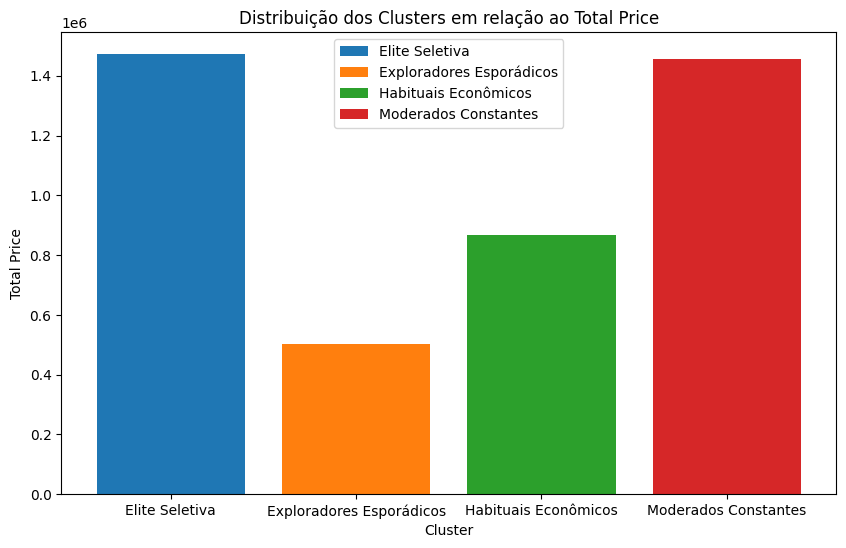

In [227]:
# Vamos agrupar os dados pelo Cluster e somar o Total Price para cada Cluster
cluster_total = df.groupby('Cluster')['Total Price'].sum().reset_index()

# Vamos criar um gráfico de barras empilhadas
plt.figure(figsize=(10, 6))

# Plotando as barras para cada cluster
for i, cluster in enumerate(cluster_total['Cluster']):
    plt.bar(cluster, cluster_total.loc[i, 'Total Price'], label=cluster)

# Adicionando legendas e título
plt.xlabel('Cluster')
plt.ylabel('Total Price')
plt.title('Distribuição dos Clusters em relação ao Total Price')
plt.legend()

# Exibindo o gráfico
plt.show()

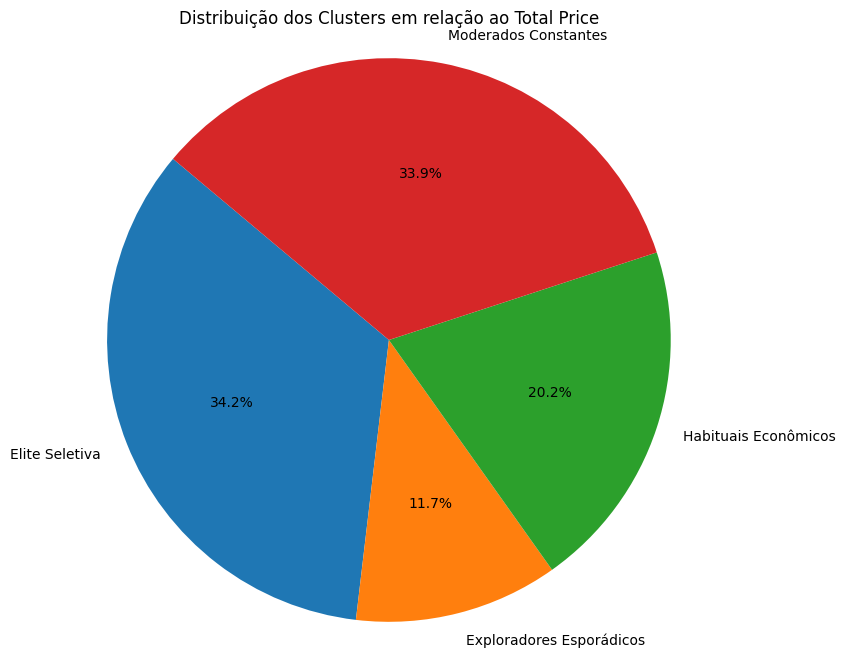

In [228]:
# Vamos agrupar os dados pelo Cluster e somar o Total Price para cada Cluster
cluster_total = df.groupby('Cluster')['Total Price'].sum()

# Criar um gráfico de rosca
plt.figure(figsize=(8, 8))
plt.pie(cluster_total, labels=cluster_total.index, autopct='%1.1f%%', startangle=140)

# Adicionando título
plt.title('Distribuição dos Clusters em relação ao Total Price')

# Exibindo o gráfico
plt.axis('equal')  # Assegura que o gráfico de pizza seja desenhado como um círculo.
plt.show()